In [1]:
import os
import warnings
import json

warnings.filterwarnings("ignore")

import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from loguru import logger
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

from src.model.utils import get_model
from src.model.hybrid import HybridNet
from src.dataset.hybrid import HybridTestPhase
from src.dataset.denoise import DenoiseTestPhase

torch.manual_seed(1234)
np.random.seed(1234)

cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
logger.info(f"Device : {device}")

def show_im(im, figsize=(20, 10)):
    plt.figure(figsize=figsize)
    if isinstance(im, list):
        plt.imshow(np.hstack([i for i in im]), cmap="gray")
    else:
        plt.imshow(im, cmap="gray")
    plt.show()


def show_multi_im(imgs: list, ratio=(5, 12), figsize=(20, 10)):
    index = 0
    f, axarr = plt.subplots(ratio[0], ratio[1], figsize=figsize)
    for r in range(ratio[0]):
        for c in range(ratio[1]):

            axarr[r, c].imshow(imgs[index], cmap="gray")
            index += 1
    plt.show()

def get_infor(data, lib="torch"):
    lib = torch if lib == "torch" else np
    return f"Max: {lib.max(data)} - Min: {lib.min(data)}"

def make_dir(config, layer):
    condition = f"{config['clip']}clip_{config['normalize']}normalize_sigrange{config['sigma_range']}_{config['output_mode']}_{config['with_map']}WithMap"
    save_dir = f"report/images/LuanVan/layers_{config['model_name']}{layer}_{condition}"
    os.makedirs(os.path.join("report", "images"), exist_ok=True)
    os.makedirs(os.path.join("report", "images", "LuanVan"), exist_ok=True)
    os.makedirs(save_dir, exist_ok=True)
    return save_dir

config = {
    "layers": [10],
    "channels": 2,
    "out_channels": 1,
    "features": 192,
    "n_workers": 1,
    "scheduler_mode": min,
    "scheduler_patience": 1,
    "model_name": "hybrid",
    "loss_function": "L1",
    "alpha_loss": [0.001],
    "sigma_range": [10,25,35,45,55],
    "weight": r"result/hybrid_dnresnet_fcn_Falseclip_Truenormalize_sigrange10_25_image_withMap/model_003.pth",
    "data_dir": "data",
    "clip": False,
    "normalize": True,
    "output_mode": 'image',
    "with_map": True
}
denoise_config = {"model_name": 'dnresnet',
    "layer": 10,
    "input_channel": 2,
    "out_channels": 1,
    "features": 192}

noisemap_config = {"model_name": 'fcn',
    "layer": 5,
    "input_channel": 1,
    "features": 32}

2023-12-23 13:39:43.988 | INFO     | __main__:<cell line: 26>:26 - Device : cuda:0


In [51]:
from src.dataset import read_npy
from torchvision import transforms

transform = transforms.ToTensor()

def create_data(npy_path, sigma,return_path, config):
    output = read_npy(npy_path)
    # Noise
    noise1 = np.random.randn(output.shape[0], output.shape[1]) * sigma
    noise2 = np.random.randn(output.shape[0], output.shape[1]) * sigma

    # Noisy Image
    noisy_img = np.sqrt((output + noise1) * (output + noise1) + noise2 * noise2)

    if config["output_mode"]!='image':
        # Noisy
        output = transform((noisy_img - output).astype(np.int32)).float()
    else:
        # CLean Image
        output = transform(output.astype(np.int32)).float()
    print(get_infor(noisy_img, 'numpy'))
    noisy_img = transform(noisy_img.astype(np.int32)).float()
    print(get_infor(noisy_img))

    if config['with_map']:
        print('with_map')
        noise_map = torch.ones_like(noisy_img) * sigma
        # noisy_img = torch.cat((noisy_img, map), dim=0)

    if config['clip']:
        print('clip')
        noise_map = noise_map.clamp(0, 255)
        output = output.clamp(0, 255)
        noisy_img = noisy_img.clamp(0, 255)

    if config['normalize']:
        print('normalize')
        noise_map = noise_map.div(55)
        output = output.div(255)
        noisy_img = noisy_img.div(255)
    print(get_infor(noisy_img))

    if return_path:
        return noisy_img.unsqueeze(0), noise_map.unsqueeze(0), output.unsqueeze(0), npy_path
    else:
        return noisy_img.unsqueeze(0), noise_map.unsqueeze(0), output.unsqueeze(0)

In [ ]:
denoise_model = get_model(
            name=denoise_config["model_name"],
            layers=denoise_config["layer"],
            input_channels=denoise_config["input_channel"],
            feature=denoise_config["features"],
            out_channels=denoise_config.get("out_channels", 1)
        )

noisemap_model = get_model(
    name=noisemap_config["model_name"],
    layers=noisemap_config["layer"],
    input_channels=noisemap_config["input_channel"],
    feature=noisemap_config["features"],
)

model = HybridNet(denoise_net=denoise_model, noisemap_net=noisemap_model)
model.eval()
check_point = torch.load(config["weight"])
# model = torch.load(os.path.join(save_dir, "model_%03d.pth" % initial_epoch))
model.load_state_dict(check_point)
model.cuda()

Max: 280.35768563285916 - Min: 0.09968694555151089
Max: 280.0 - Min: 0.0
with_map
normalize
Max: 1.0980392694473267 - Min: 0.0


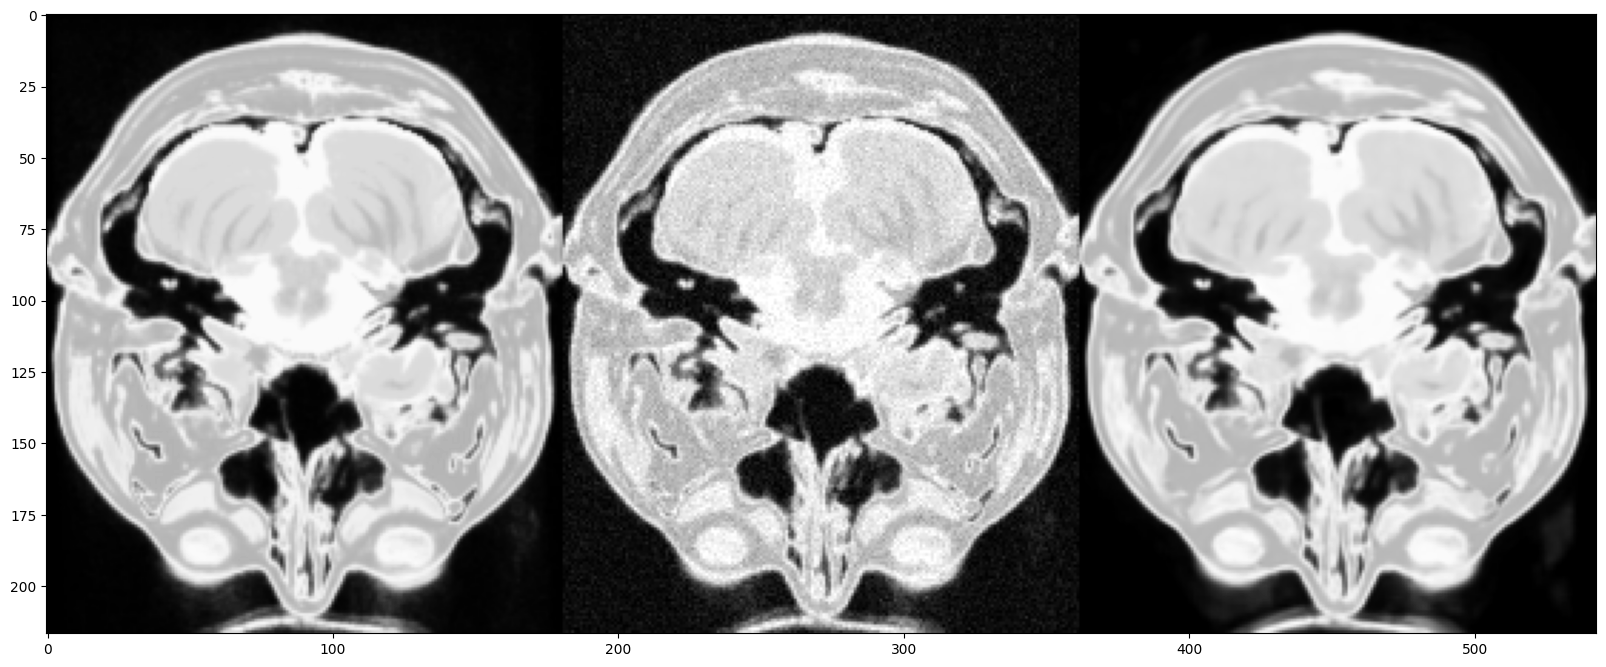

In [61]:
npy_path="data/test/origin/25synBrainPd.npy"
sigma = 10

noisy_img, noise_map, output = create_data(
    npy_path=npy_path,
    sigma=sigma,
    return_path=False,
    config=config
)
predicted_noise_level, predicted_output = model(noisy_img.cuda())
output = output.cuda()
if config['output_mode'] != 'image':
    clean_imgs = noisy_img - output
    denoise_imgs = noisy_img - predicted_output
else:
    clean_imgs = output
    denoise_imgs = predicted_output
if config['normalize']:
    clean_imgs = clean_imgs * 255
    denoise_imgs = denoise_imgs * 255
    predicted_noise_level = predicted_noise_level * 55
    noise_map = noise_map * 55

clean_imgs = clean_imgs.clamp(0, 255)
denoise_imgs = denoise_imgs.clamp(0, 255)

clean_imgs = clean_imgs.cpu().detach().numpy().astype(np.uint8).squeeze(0).squeeze(0)
denoise_imgs = denoise_imgs.cpu().detach().numpy().astype(np.uint8).squeeze(0).squeeze(0)
if noisy_img.shape[1] == 2:
    noisy_img = noisy_img[:,0,:,:]
    noisy_img = (noisy_img*255).clamp(0,255).cpu().detach().numpy().astype(np.uint8).squeeze(0)
else:
    noisy_img = (noisy_img*255).clamp(0,255).cpu().detach().numpy().astype(np.uint8).squeeze(0).squeeze(0)
show_im([clean_imgs, noisy_img, denoise_imgs])
